In [24]:
import pandas as pd
import numpy as np
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV
# import xgboost as xgb
from sklearn.metrics import precision_recall_curve
import altair as alt
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import shap
import altair as alt
import pickle
from joblib import dump, load
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt

# Prepare the Data

In [6]:
df10 = pd.read_csv('drive-download-20220307T231112Z-001/corp_trends2010.csv')
df12 = pd.read_csv('drive-download-20220307T231112Z-001/corp_trends2012.csv')
df14 = pd.read_csv('drive-download-20220307T231112Z-001/corp_trends2014.csv')
df16 = pd.read_csv('drive-download-20220307T231112Z-001/corp_trends2016.csv')
df18 = pd.read_csv('drive-download-20220307T231112Z-001/corp_trends2018.csv')
df20 = pd.read_csv('drive-download-20220307T231112Z-001/corp_trends2020.csv')
trends = [df10,df12,df14,df16,df18,df20]

In [7]:
newTrends = []
years = [2010,2012,2014,2016,2018,2020]
for i in range(len(years)):
    j = trends[i].rename(columns={"Unnamed: 0": "state"})
    y = years[i]
    j['year'] = y
    newTrends.append(j)

In [8]:
newTrends
# ndf  = df10.copy()
lTrends = newTrends.pop(0)
for i in newTrends:
    lTrends = lTrends.append(i)
X = lTrends.copy()
X

,state,3M Company,AT&T,Absolut,Adidas,Airbnb,Aldi,Allstate,Amazon,American Airlines,...,Wells Fargo,Wendys,White Claw,Whole Foods,Wish.com,Woodford Reserve,Yum!,Zoom,eBay,year
0,Alaska,0,70,10,44,56,3,70,91,45,...,100,21,0,14,0,0,0,77,76,2010
1,Alabama,33,85,53,42,13,39,59,75,38,...,17,48,0,39,0,6,0,86,90,2010
2,Arkansas,21,77,21,49,17,18,41,63,63,...,18,46,0,32,83,3,0,73,94,2010
3,Arizona,14,37,45,47,21,11,44,80,63,...,79,52,0,48,55,3,0,81,68,2010
4,California,10,42,68,98,51,38,25,64,46,...,41,20,14,54,8,2,0,95,53,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,Washington,32,31,54,53,79,2,48,95,31,...,37,38,62,27,52,10,0,82,53,2020
47,Wisconsin,37,41,73,63,58,78,29,86,44,...,24,36,70,14,58,13,0,55,64,2020
48,West Virginia,18,66,44,35,30,53,52,85,20,...,8,87,56,4,100,20,0,36,100,2020
49,Wyoming,0,28,35,33,50,3,52,96,29,...,62,55,59,7,54,4,0,47,63,2020


In [9]:
ef10 = pd.read_csv('elections data/2010_election_data.csv')
ef12 = pd.read_csv('elections data/2012_election_data.csv')
ef14 = pd.read_csv('elections data/2014_election_data.csv')
ef16 = pd.read_csv('elections data/2016_election_data.csv')
ef18 = pd.read_csv('elections data/2018_election_data.csv')
ef20 = pd.read_csv('elections data/2020_election_data.csv')
elections = [ef10,ef12,ef14,ef16,ef18,ef20]

In [10]:
start = elections.pop(0)
# newLabels = []
years = [2010,2012,2014,2016,2018,2020]
for i in elections:
    j = i.drop("Unnamed: 0",axis=1)
    start = start.append(j)
Y = start.copy()

In [11]:
Y = Y.fillna(0)
Y['maskActual'] = Y['rep_votes_share'].apply(lambda x: round(x))
fv = pd.merge(X,Y,on=['state','year'])
fv = fv.drop(['Doordash'],axis=1)
fv

,state,3M Company,AT&T,Absolut,Adidas,Airbnb,Aldi,Allstate,Amazon,American Airlines,...,year,Unnamed: 0,DEMOCRAT,INDEPENDENT,REPUBLICAN,Total,dem_votes_share,rep_votes_share,indep_votes_share,maskActual
0,Alaska,0,70,10,44,56,3,70,91,45,...,2010,1.0,77606.0,0.0,175384.0,252990.0,0.306755,0.693245,0.000000,1
1,Alabama,33,85,53,42,13,39,59,75,38,...,2010,0.0,418957.0,0.0,914445.0,1333402.0,0.314202,0.685798,0.000000,1
2,Arkansas,21,77,21,49,17,18,41,63,63,...,2010,3.0,317975.0,4421.0,435422.0,757818.0,0.419593,0.574573,0.005834,1
3,Arizona,14,37,45,47,21,11,44,80,63,...,2010,2.0,711837.0,4506.0,900510.0,1616853.0,0.440261,0.556952,0.002787,1
4,California,10,42,68,98,51,38,25,64,46,...,2010,4.0,5148828.0,23628.0,4195494.0,9367950.0,0.549622,0.447856,0.002522,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Vermont,0,32,100,34,71,12,36,100,40,...,2020,0.0,238827.0,16206.0,95830.0,350863.0,0.680684,0.273127,0.046189,0
296,Washington,32,31,54,53,79,2,48,95,31,...,2020,0.0,2340356.0,0.0,1545436.0,3885792.0,0.602285,0.397715,0.000000,0
297,Wisconsin,37,41,73,63,58,78,29,86,44,...,2020,0.0,1566671.0,7911.0,1661399.0,3235981.0,0.484141,0.513414,0.002445,1
298,West Virginia,18,66,44,35,30,53,52,85,20,...,2020,0.0,246903.0,0.0,514268.0,761171.0,0.324373,0.675627,0.000000,1


# Run Cross Validation

In [27]:
def crossValidation(fv,years):
    scores = {}
    models = []
    for year in years:
        train = fv[fv['year'] != year]
        test = fv[fv['year'] == year]

        Xtrain = train.loc[:, '3M Company':'eBay']
        Xtest = test.loc[:, '3M Company':'eBay']

        YtrainR = train['rep_votes_share']
        YtestR = test['rep_votes_share']
        YtrainC = train['maskActual']
        YtestC = test['maskActual']
        
        params = { 'max_depth': [3,5,7,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100,250, 500, 1000],
           'colsample_bytree': [0.3,0.5, 0.7],
          'alpha':[0.0,0.01,0.1,0.5,1.0],
          'lambda':[0.0,0.01,0.1,0.5,1.0],
          'tree_method':['exact','gpu_hist'],
#           'eval_metric': ['error','logloss'],
          'objective': ['binary:logistic']
         }
        
        xgbr = xgb.XGBClassifier(seed = 42)

        xgbCLF = RandomizedSearchCV(estimator=xgbr, 
                           param_distributions=params,
                           scoring='neg_mean_squared_error', 
                           verbose=2,
                              n_jobs = -1)
        xgbCLF.fit(Xtrain,YtrainC)
        xgbBest = xgbCLF.best_estimator_
        XGBpredictions = xgbBest.predict(Xtest)
        acc = accuracy_score(YtestC, XGBpredictions)
        scores[year] = acc
        models.append(xgbBest)
        
    return (scores,models)

In [28]:
results = crossValidation(fv,[2010,2012,2014,2016,2018,2020])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


One or more of the test scores are non-finite: [   nan    nan    nan    nan    nan -0.116 -0.108 -0.124    nan    nan]
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:15:15] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


One or more of the test scores are non-finite: [-0.104    nan    nan    nan    nan -0.104    nan -0.104    nan -0.1  ]
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:15:18] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


One or more of the test scores are non-finite: [-0.132    nan -0.124    nan -0.148 -0.136    nan    nan -0.124    nan]
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:15:23] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


One or more of the test scores are non-finite: [   nan    nan -0.096 -0.1      nan -0.112    nan    nan    nan -0.12 ]
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:15:25] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


One or more of the test scores are non-finite: [-0.116    nan    nan -0.112    nan -0.136 -0.116 -0.112 -0.124    nan]
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:15:29] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


One or more of the test scores are non-finite: [   nan -0.128 -0.12     nan -0.124 -0.128 -0.116    nan -0.112    nan]
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:15:32] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [30]:
results[0]

{2010: 0.84, 2012: 0.84, 2014: 0.92, 2016: 0.9, 2018: 0.88, 2020: 0.9}

# Start regression

In [32]:
xgb.XGBRegressor()

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [12]:
train = fv[fv['year'] != 2020]
test = fv[fv['year'] == 2020]

Xtrain = train.loc[:, '3M Company':'eBay']
Xtest = test.loc[:, '3M Company':'eBay']

YtrainR = train['rep_votes_share']
YtestR = test['rep_votes_share']
YtrainC = train['maskActual']
YtestC = test['maskActual']

In [8]:
train = fv[fv['year'] != 2020]
test = fv[fv['year'] == 2020]

Xtrain = train.loc[:, '3M Company':'eBay']
Xtest = test.loc[:, '3M Company':'eBay']

YtrainR = train['rep_votes_share']
YtestR = test['rep_votes_share']
YtrainC = train['maskActual']
YtestC = test['maskActual']

params = { 'max_depth': [3,5,7,10],
   'learning_rate': [0.01, 0.05, 0.1],
   'n_estimators': [100,250, 500, 1000],
   'colsample_bytree': [0.3,0.5, 0.7],
  'alpha':[0.0,0.01,0.1,0.5,1.0],
  'lambda':[0.0,0.01,0.1,0.5,1.0],
  'tree_method':['exact','gpu_hist'],
#           'eval_metric': ['error','logloss'],
  'objective': ['reg:squarederror','reg:squaredlogerror','reg:logistic','reg:pseudohubererror','reg:gamma','reg:tweedie']
 }


xgbr = xgb.XGBRegressor(seed=42)

xgbRegress = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_absolute_error', 
                   verbose=2,
                      n_jobs = -1)
xgbRegress.fit(Xtrain,YtrainR)
xgbBest = xgbRegress.best_estimator_

Fitting 5 folds for each of 43200 candidates, totalling 216000 fits


One or more of the test scores are non-finite: [-0.06709873         nan -0.06692776 ...         nan -0.05643555
         nan]


In [13]:
filename = 'xgbRegBase.sav'
pickle.dump(xgbRegress, open(filename, 'wb'))

In [4]:
file = open('xgbRegBase.sav', 'rb')
xgbRegress = pickle.load(file)

In [14]:
xgbBest = xgbRegress.best_estimator_

In [25]:
xgbBest

XGBRegressor(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=0.1, learning_rate=0.05,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=20,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.00999999978, reg_lambda=0.100000001,
             scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
             validate_parameters=1, ...)

In [75]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBest.predict(Xtrain)
# Calculate the absolute errors
errors = abs(XGBpredictions - YtrainR)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Mean Absolute Error: 0.0014733959330016269 degrees.


In [76]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBest.predict(Xtest)
# Calculate the absolute errors
errors = abs(XGBpredictions - YtestR)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Mean Absolute Error: 0.05992149363111375 degrees.


In [15]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBest.predict(Xtest)
# Calculate the absolute errors
errors = (XGBpredictions - YtestR)**2
# Print out the mean absolute error (mae)
print('Mean Squared Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Mean Squared Error: 0.00776534113005536 degrees.


In [16]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBest.predict(Xtrain)
# Calculate the absolute errors
errors = (XGBpredictions - YtrainR)**2
# Print out the mean absolute error (mae)
print('Mean Squared Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Mean Squared Error: 3.607957750636028e-06 degrees.


In [17]:
xNew = Xtest.append(Xtrain)
XGBpredictions = xgbBest.predict(xNew)
fv['predR'] = XGBpredictions
fv['predRMask'] = fv['predR'].apply(lambda x: round(x))

In [20]:
# XGBpredictions = xgbBest.predict(Xtrain)
traindf = fv[fv['year'] < 2020]
trainPred = traindf['predRMask']
print('Accuracy:',accuracy_score(YtrainC, trainPred))

Accuracy: 0.848


In [22]:
# XGBpredictions = xgbBest.predict(Xtrain)
traindf = fv[fv['year'] == 2020]
trainPred = traindf['predRMask']
print('Accuracy:',accuracy_score(YtestC, trainPred))

Accuracy: 0.88


In [68]:
cdf = pd.DataFrame(columns=['pred','actual','absError','sqError'])
cdf['pred'] = xgbBest.predict(Xtest)
cdf['actual'] = list(YtestR)
cdf['absError'] = abs(cdf['pred'] - cdf['actual'])
cdf['sqError'] = (cdf['pred'] - cdf['actual'])**2

In [72]:
cdf

,pred,actual,absError,sqError
0,0.543170,0.545840,0.002671,7.133142e-06
1,0.580510,0.699327,0.118817,1.411749e-02
2,0.608332,0.714792,0.106460,1.133377e-02
3,0.461826,0.501407,0.039582,1.566696e-03
4,0.339335,0.337262,0.002073,4.298808e-06
5,0.451820,0.450806,0.001015,1.029981e-06
6,0.385949,0.394279,0.008330,6.939429e-05
7,0.425198,0.411056,0.014142,1.999848e-04
8,0.447953,0.525303,0.077349,5.982940e-03
9,0.506626,0.509963,0.003337,1.113659e-05


In [70]:
np.mean(cdf['sqError'])

0.00776534113005536

In [71]:
np.mean(cdf['absError'])

0.05992149363111375

In [22]:
xNew = Xtrain.append(Xtest)

In [23]:
XGBpredictions = xgbBest.predict(xNew)
fv['predR'] = XGBpredictions
fv['predRMask'] = fv['predR'].apply(lambda x: round(x))

In [24]:
fv

,state,3M Company,AT&T,Absolut,Adidas,Airbnb,Aldi,Allstate,Amazon,American Airlines,...,DEMOCRAT,INDEPENDENT,REPUBLICAN,Total,dem_votes_share,rep_votes_share,indep_votes_share,maskActual,predR,predRMask
0,Alaska,0,70,10,44,56,3,70,91,45,...,77606.0,0.0,175384.0,252990.0,0.306755,0.693245,0.000000,1,0.692695,1
1,Alabama,33,85,53,42,13,39,59,75,38,...,418957.0,0.0,914445.0,1333402.0,0.314202,0.685798,0.000000,1,0.682820,1
2,Arkansas,21,77,21,49,17,18,41,63,63,...,317975.0,4421.0,435422.0,757818.0,0.419593,0.574573,0.005834,1,0.577716,1
3,Arizona,14,37,45,47,21,11,44,80,63,...,711837.0,4506.0,900510.0,1616853.0,0.440261,0.556952,0.002787,1,0.558318,1
4,California,10,42,68,98,51,38,25,64,46,...,5148828.0,23628.0,4195494.0,9367950.0,0.549622,0.447856,0.002522,0,0.448757,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Vermont,0,32,100,34,71,12,36,100,40,...,238827.0,16206.0,95830.0,350863.0,0.680684,0.273127,0.046189,0,0.275328,0
296,Washington,32,31,54,53,79,2,48,95,31,...,2340356.0,0.0,1545436.0,3885792.0,0.602285,0.397715,0.000000,0,0.423421,0
297,Wisconsin,37,41,73,63,58,78,29,86,44,...,1566671.0,7911.0,1661399.0,3235981.0,0.484141,0.513414,0.002445,1,0.465251,0
298,West Virginia,18,66,44,35,30,53,52,85,20,...,246903.0,0.0,514268.0,761171.0,0.324373,0.675627,0.000000,1,0.564827,1


In [35]:
analysis = fv[['state','rep_votes_share','dem_votes_share','maskActual','predR','predRMask','year']]
analysis['margin'] = analysis['rep_votes_share'] - analysis['dem_votes_share']
analysis['error margin'] = abs(analysis['predR'] - analysis['rep_votes_share'])
analysis['predMargin'] = analysis['predR'] - (1-analysis['predR'])
# analysis['pred'] = bLogReg.predict(Xtest)
errors = []
for i, r in analysis.iterrows():
    a = r['maskActual']
    p = r['predRMask']
    if (a==1) and (p==1):
        errors.append(1)
    elif (a==1) and (p!=1):
        errors.append(0.5)
    elif (a==0) and (p==0):
        errors.append(-1)
    else:
        errors.append(-0.5)
analysis['errors'] = errors


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [36]:
analysis.to_csv('regressionXGBanalysis.csv')

In [37]:
analysis

,state,rep_votes_share,dem_votes_share,maskActual,predR,predRMask,year,margin,error margin,predMargin,errors
0,Alaska,0.693245,0.306755,1,0.692695,1,2010,0.386490,0.000550,0.385390,1.0
1,Alabama,0.685798,0.314202,1,0.682820,1,2010,0.371597,0.002978,0.365641,1.0
2,Arkansas,0.574573,0.419593,1,0.577716,1,2010,0.154980,0.003143,0.155433,1.0
3,Arizona,0.556952,0.440261,1,0.558318,1,2010,0.116691,0.001365,0.116636,1.0
4,California,0.447856,0.549622,0,0.448757,0,2010,-0.101765,0.000901,-0.102486,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
295,Vermont,0.273127,0.680684,0,0.275328,0,2020,-0.407558,0.002202,-0.449343,-1.0
296,Washington,0.397715,0.602285,0,0.423421,0,2020,-0.204571,0.025707,-0.153158,-1.0
297,Wisconsin,0.513414,0.484141,1,0.465251,0,2020,0.029273,0.048163,-0.069497,0.5
298,West Virginia,0.675627,0.324373,1,0.564827,1,2020,0.351255,0.110800,0.129655,1.0


In [39]:
from collections import Counter
nA = analysis[analysis['year']==2020]
Counter(nA['errors'])

Counter({1.0: 23, 0.5: 6, -1.0: 21})

In [43]:
44/50

0.88

0.5525494666449677

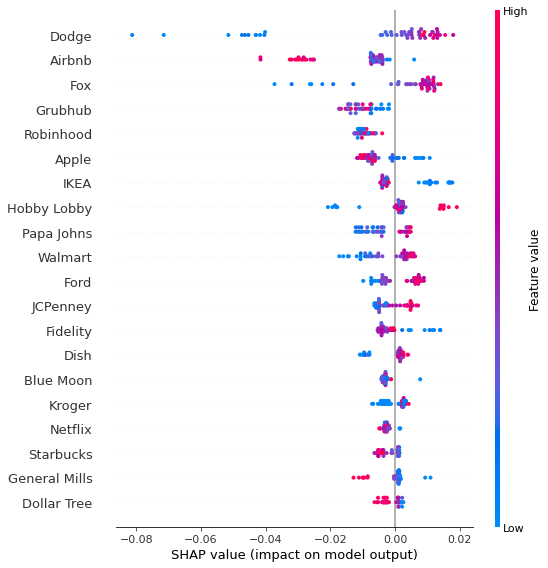

In [26]:
explainer = shap.Explainer(xgbBest, Xtrain)
shap_values = explainer.shap_values(Xtest)
shap_obj = explainer(Xtest)
# shap.plots.beeswarm(shap_obj)
shap.summary_plot(shap_values, Xtest)

In [82]:
test.reset_index()

,index,state,3M Company,AT&T,Absolut,Adidas,Airbnb,Aldi,Allstate,Amazon,...,year,Unnamed: 0,DEMOCRAT,INDEPENDENT,REPUBLICAN,Total,dem_votes_share,rep_votes_share,indep_votes_share,maskActual
0,250,Alaska,0,63,56,28,62,1,66,82,...,2020,0.0,159856.0,0.0,192126.0,351982.0,0.454160,0.545840,0.000000,1
1,251,Alabama,35,73,65,60,60,44,92,78,...,2020,0.0,608809.0,0.0,1416012.0,2024821.0,0.300673,0.699327,0.000000,1
2,252,Arkansas,28,81,47,48,55,21,47,72,...,2020,0.0,330485.0,0.0,828266.0,1158751.0,0.285208,0.714792,0.000000,1
3,253,Arizona,29,28,53,59,80,7,56,85,...,2020,0.0,1629318.0,0.0,1638516.0,3267834.0,0.498593,0.501407,0.000000,1
4,254,California,32,47,56,84,88,17,42,82,...,2020,0.0,11084234.0,0.0,5640667.0,16724901.0,0.662738,0.337262,0.000000,0
5,255,Colorado,27,30,60,51,77,3,56,80,...,2020,0.0,1679052.0,0.0,1378248.0,3057300.0,0.549194,0.450806,0.000000,0
6,256,Connecticut,45,33,88,66,62,41,48,84,...,2020,0.0,1022792.0,16729.0,676650.0,1716171.0,0.595973,0.394279,0.009748,0
7,257,Delaware,0,30,57,51,44,36,47,100,...,2020,0.0,281382.0,0.0,196392.0,477774.0,0.588944,0.411056,0.000000,0
8,258,Florida,33,48,69,66,85,57,56,91,...,2020,0.0,4942287.0,0.0,5469163.0,10411450.0,0.474697,0.525303,0.000000,1
9,259,Georgia,30,68,60,76,79,46,73,77,...,2020,0.0,2393089.0,0.0,2490396.0,4883485.0,0.490037,0.509963,0.000000,1


In [27]:
explainer = shap.KernelExplainer(xgbBest)
shap_values = explainer.shap_values(Xtest)

TypeError: __init__() missing 1 required positional argument: 'data'

In [28]:
shap.force_plot(explainer.expected_value, shap_values[42,:], Xtest.iloc[42,:])

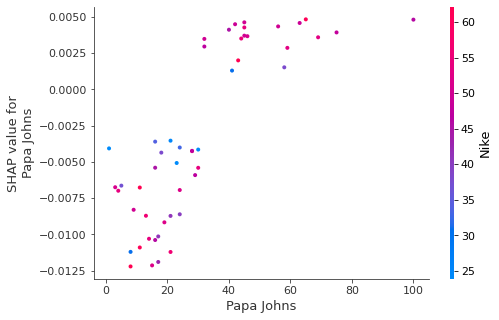

In [136]:
shap.dependence_plot("Papa Johns", shap_values, Xtest)

In [117]:
test.reset_index()

,index,state,3M Company,AT&T,Absolut,Adidas,Airbnb,Aldi,Allstate,Amazon,...,year,Unnamed: 0,DEMOCRAT,INDEPENDENT,REPUBLICAN,Total,dem_votes_share,rep_votes_share,indep_votes_share,maskActual
0,250,Alaska,0,63,56,28,62,1,66,82,...,2020,0.0,159856.0,0.0,192126.0,351982.0,0.454160,0.545840,0.000000,1
1,251,Alabama,35,73,65,60,60,44,92,78,...,2020,0.0,608809.0,0.0,1416012.0,2024821.0,0.300673,0.699327,0.000000,1
2,252,Arkansas,28,81,47,48,55,21,47,72,...,2020,0.0,330485.0,0.0,828266.0,1158751.0,0.285208,0.714792,0.000000,1
3,253,Arizona,29,28,53,59,80,7,56,85,...,2020,0.0,1629318.0,0.0,1638516.0,3267834.0,0.498593,0.501407,0.000000,1
4,254,California,32,47,56,84,88,17,42,82,...,2020,0.0,11084234.0,0.0,5640667.0,16724901.0,0.662738,0.337262,0.000000,0
5,255,Colorado,27,30,60,51,77,3,56,80,...,2020,0.0,1679052.0,0.0,1378248.0,3057300.0,0.549194,0.450806,0.000000,0
6,256,Connecticut,45,33,88,66,62,41,48,84,...,2020,0.0,1022792.0,16729.0,676650.0,1716171.0,0.595973,0.394279,0.009748,0
7,257,Delaware,0,30,57,51,44,36,47,100,...,2020,0.0,281382.0,0.0,196392.0,477774.0,0.588944,0.411056,0.000000,0
8,258,Florida,33,48,69,66,85,57,56,91,...,2020,0.0,4942287.0,0.0,5469163.0,10411450.0,0.474697,0.525303,0.000000,1
9,259,Georgia,30,68,60,76,79,46,73,77,...,2020,0.0,2393089.0,0.0,2490396.0,4883485.0,0.490037,0.509963,0.000000,1


In [121]:
test

,state,3M Company,AT&T,Absolut,Adidas,Airbnb,Aldi,Allstate,Amazon,American Airlines,...,year,Unnamed: 0,DEMOCRAT,INDEPENDENT,REPUBLICAN,Total,dem_votes_share,rep_votes_share,indep_votes_share,maskActual
250,Alaska,0,63,56,28,62,1,66,82,29,...,2020,0.0,159856.0,0.0,192126.0,351982.0,0.454160,0.545840,0.000000,1
251,Alabama,35,73,65,60,60,44,92,78,33,...,2020,0.0,608809.0,0.0,1416012.0,2024821.0,0.300673,0.699327,0.000000,1
252,Arkansas,28,81,47,48,55,21,47,72,45,...,2020,0.0,330485.0,0.0,828266.0,1158751.0,0.285208,0.714792,0.000000,1
253,Arizona,29,28,53,59,80,7,56,85,100,...,2020,0.0,1629318.0,0.0,1638516.0,3267834.0,0.498593,0.501407,0.000000,1
254,California,32,47,56,84,88,17,42,82,42,...,2020,0.0,11084234.0,0.0,5640667.0,16724901.0,0.662738,0.337262,0.000000,0
255,Colorado,27,30,60,51,77,3,56,80,47,...,2020,0.0,1679052.0,0.0,1378248.0,3057300.0,0.549194,0.450806,0.000000,0
256,Connecticut,45,33,88,66,62,41,48,84,42,...,2020,0.0,1022792.0,16729.0,676650.0,1716171.0,0.595973,0.394279,0.009748,0
257,Delaware,0,30,57,51,44,36,47,100,55,...,2020,0.0,281382.0,0.0,196392.0,477774.0,0.588944,0.411056,0.000000,0
258,Florida,33,48,69,66,85,57,56,91,87,...,2020,0.0,4942287.0,0.0,5469163.0,10411450.0,0.474697,0.525303,0.000000,1
259,Georgia,30,68,60,76,79,46,73,77,33,...,2020,0.0,2393089.0,0.0,2490396.0,4883485.0,0.490037,0.509963,0.000000,1


In [29]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, Xtest)

In [100]:
shap.force_plot(explainer.expected_value[42], shap_values[42], Xtest.iloc[42, :])

IndexError: invalid index to scalar variable.

In [23]:
shap.initjs()
shap.force_plot(shap_values)

NameError: name 'shap_values' is not defined

In [43]:
YtestR

250    0.545840
251    0.699327
252    0.714792
253    0.501407
254    0.337262
255    0.450806
256    0.394279
257    0.411056
258    0.525303
259    0.509963
260    0.304357
261    0.529952
262    0.687208
263    0.417304
264    0.592691
265    0.582001
266    0.649698
267    0.647436
268    0.219701
269    0.349605
270    0.420452
271    0.493343
272    0.573281
273    0.595274
274    0.657112
275    0.563864
276    0.497241
277    0.714539
278    0.642231
279    0.461032
280    0.420578
281    0.451307
282    0.487802
283    0.363325
284    0.570243
285    0.681560
286    0.429277
287    0.506334
288    0.225986
289    0.567461
290    1.000000
291    0.593044
292    0.545504
293    0.633185
294    0.475003
295    0.273127
296    0.397715
297    0.513414
298    0.675627
299    0.736132
Name: rep_votes_share, dtype: float64

# Variance Analyis

In [122]:
fv.head()

,state,3M Company,AT&T,Absolut,Adidas,Airbnb,Aldi,Allstate,Amazon,American Airlines,...,DEMOCRAT,INDEPENDENT,REPUBLICAN,Total,dem_votes_share,rep_votes_share,indep_votes_share,maskActual,predR,predRMask
0,Alaska,0,70,10,44,56,3,70,91,45,...,77606.0,0.0,175384.0,252990.0,0.306755,0.693245,0.000000,1,0.692695,1
1,Alabama,33,85,53,42,13,39,59,75,38,...,418957.0,0.0,914445.0,1333402.0,0.314202,0.685798,0.000000,1,0.682820,1
2,Arkansas,21,77,21,49,17,18,41,63,63,...,317975.0,4421.0,435422.0,757818.0,0.419593,0.574573,0.005834,1,0.577716,1
3,Arizona,14,37,45,47,21,11,44,80,63,...,711837.0,4506.0,900510.0,1616853.0,0.440261,0.556952,0.002787,1,0.558318,1
4,California,10,42,68,98,51,38,25,64,46,...,5148828.0,23628.0,4195494.0,9367950.0,0.549622,0.447856,0.002522,0,0.448757,0


In [130]:
gb = fv[['state','rep_votes_share']]
np.mean((gb.groupby(by='state').var()).reset_index()['rep_votes_share'])

0.0031238591629809153

In [135]:
gb = fv[['state','Walmart']]
np.mean((gb.groupby(by='state').var()).reset_index()['Walmart'])

44.294000000000004

In [133]:
list(fv.columns)

['state',
 '3M Company',
 'AT&T',
 'Absolut',
 'Adidas',
 'Airbnb',
 'Aldi',
 'Allstate',
 'Amazon',
 'American Airlines',
 'American Express',
 'Apple',
 'BP',
 'Bacardi',
 'Bank of America',
 'Berkshire Hathaway',
 'Best Buy',
 'Blue Moon',
 'Boeing',
 'Bud Light',
 'Budwesier',
 'Bulleit',
 'Burger King',
 'CVS',
 'Capital One',
 'Captain Morgan',
 'Casamigos',
 'Charter',
 'Chewy',
 'Chick-fil-A',
 'Chipotle',
 'Citigroup',
 'Clorox Company',
 'Coca-Cola',
 'Comcast',
 'Coors Brewing',
 'Corona Beer',
 'Costco',
 'Crown Royal',
 'Dell',
 'Delta Air Lines',
 'Dicks Sporting Goods',
 'Dish',
 'Disney',
 'Dodge',
 'Dollar General',
 'Dollar Tree',
 'Dominos Pizza',
 'DoorDash',
 'Dos Equis',
 'Electronic Arts',
 'Evan Willaims',
 'ExxonMobil',
 'Facebook',
 'FedEx',
 'Fiat Chrysler',
 'Fidelity',
 'Fireball',
 'Ford',
 'Forever 21',
 'Fox',
 'GameStop',
 'General Electric',
 'General Mills',
 'General Motors',
 'Goldman Sachs',
 'Google',
 'Goya',
 'Grey Goose',
 'Grubhub',
 'Guinness